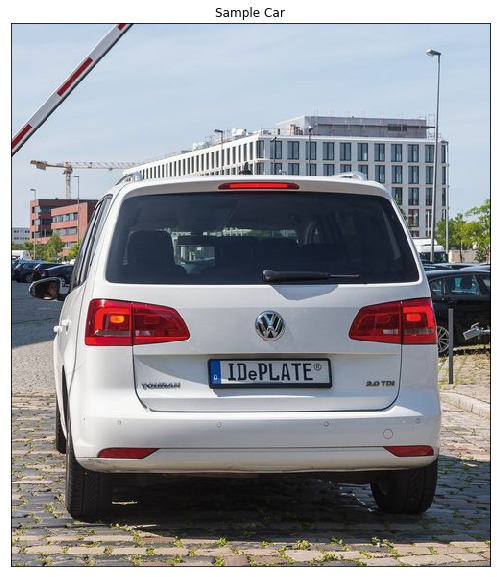

In [2]:
#Use the following function when reading an image through OpenCV and displaying through plt.
def showfig(image, ucmap):
    #There is a difference in pixel ordering in OpenCV and Matplotlib.
    #OpenCV follows BGR order, while matplotlib follows RGB order.
    if len(image.shape)==3 :
        b,g,r = cv2.split(image)       # get b,g,r
        image = cv2.merge([r,g,b])     # switch it to rgb
    imgplot=plt.imshow(image, ucmap)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    
#import Opencv library
try:
    import cv2
except ImportError:
    print ("You must have OpenCV installed")
    exit(1)

#check the OpenCV version
try:
    v=cv2.__version__
    assert (tuple(map(int,v.split(".")))>(2,4,3))
except (AssertionError, ValueError):
    print ("Install newer version of OpenCV than 2.4.3, i.e from 2.4.4")
    exit(1)

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

plt.rcParams['figure.figsize'] = 10, 10 

# Actual Code starts here
plt.title('Sample Car')
image_path="C:\\Users\\pogi\\car2.jpg"
carsample=cv2.imread(image_path)
showfig(carsample,None)

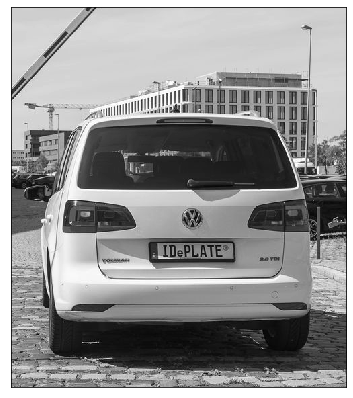

In [3]:
plt.rcParams['figure.figsize'] = 7,7

# convert into grayscale
gray_carsample=cv2.cvtColor(carsample, cv2.COLOR_BGR2GRAY)
showfig(gray_carsample, plt.get_cmap('gray'))

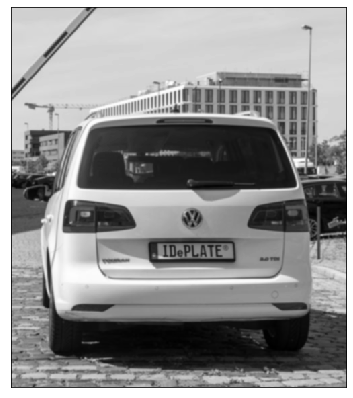

In [4]:
# blur the image
blur=cv2.GaussianBlur(gray_carsample,(5,5),0)
showfig(blur, plt.get_cmap('gray'))

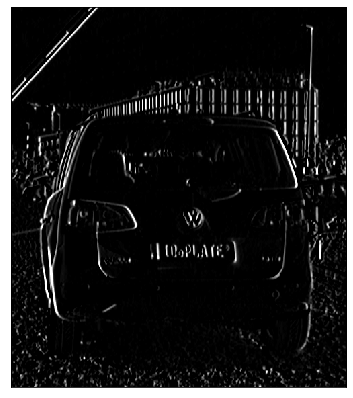

In [5]:
# find the sobel gradient. use the kernel size to be 3
sobelx=cv2.Sobel(blur, cv2.CV_8U, 1, 0, ksize=3)
showfig(sobelx, plt.get_cmap('gray'))

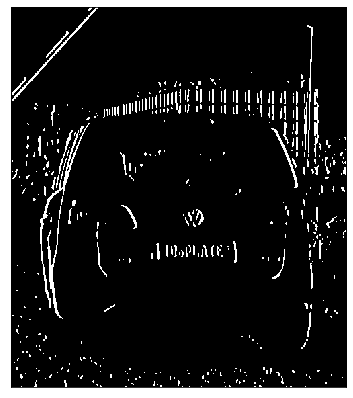

In [6]:
#Otsu thresholding
_,th2=cv2.threshold(sobelx, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
showfig(th2, plt.get_cmap('gray'))

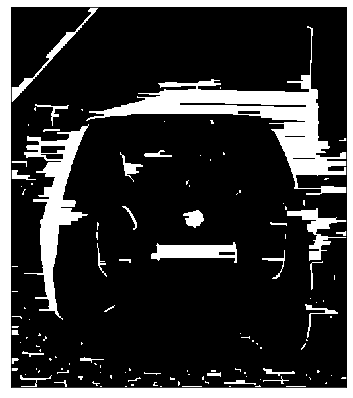

In [7]:
#Morphological Closing
se=cv2.getStructuringElement(cv2.MORPH_RECT,(23,2))
closing=cv2.morphologyEx(th2, cv2.MORPH_CLOSE, se)
showfig(closing, plt.get_cmap('gray'))

In [8]:
_,contours,_=cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

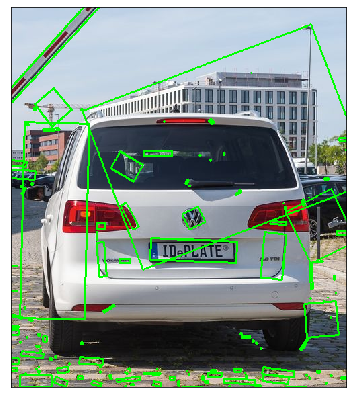

In [9]:
#pip uninstall opencv-python
#pip install opencv-contrib-python
#pip install opencv_python==3.4.2.16 
#pip install opencv-contrib-python==3.4.2.16
for cnt in contours: 
    rect=cv2.minAreaRect(cnt)  
    box=cv2.boxPoints(rect) 
    box=np.int0(box)  
    cv2.drawContours(carsample, [box], 0, (0,255,0),2)
showfig(carsample, None)

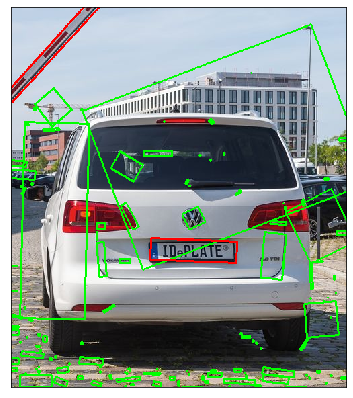

In [10]:
#validate a contour. We validate by estimating a rough area and aspect ratio check.
def validate(cnt):    
    rect=cv2.minAreaRect(cnt)  
    box=cv2.boxPoints(rect) 
    box=np.int0(box)  
    output=False
    width=rect[1][0]
    height=rect[1][1]
    if ((width!=0) & (height!=0)):
        if (((height/width>3) & (height>width)) | ((width/height>3) & (width>height))):
            if((height*width<16000) & (height*width>3000)): 
                output=True
    return output

#Lets draw validated contours with red.
for cnt in contours:
    if validate(cnt):
        rect=cv2.minAreaRect(cnt)  
        box=cv2.boxPoints(rect) 
        box=np.int0(box)  
        cv2.drawContours(carsample, [box], 0, (0,0,255),2)
showfig(carsample, None)

In [11]:
# defining a function doing this will come handy.
def generate_seeds(centre, width, height):
    minsize=int(min(width, height))
    seed=[None]*10
    for i in range(10):
        random_integer1=np.random.randint(1000)
        random_integer2=np.random.randint(1000)
        seed[i]=(centre[0]+random_integer1%int(minsize/2)-int(minsize/2),centre[1]+random_integer2%int(minsize/2)-int(minsize/2))
    return seed

In [12]:
#masks are nothing but those floodfilled images per seed.
def generate_mask(image, seed_point):
    h=carsample.shape[0]
    w=carsample.shape[1]
    #OpenCV wants its mask to be exactly two pixels greater than the source image.
    mask=np.zeros((h+2, w+2), np.uint8)
    #We choose a color difference of (50,50,50). Thats a guess from my side.
    lodiff=50
    updiff=50
    connectivity=4
    newmaskval=255
    flags=connectivity+(newmaskval<<8)+cv2.FLOODFILL_FIXED_RANGE+cv2.FLOODFILL_MASK_ONLY
    _=cv2.floodFill(image, mask, seed_point, (255, 0, 0),
                    (lodiff, lodiff, lodiff), (updiff, updiff, updiff), flags)
    return mask

In [13]:
# we will need a fresh copy of the image so as to draw masks.
carsample_mask=cv2.imread(image_path)

# for viewing the different masks later
mask_list=[]

for cnt in contours:
    if validate(cnt):
        rect=cv2.minAreaRect(cnt) 
        centre=(int(rect[0][0]), int(rect[0][1]))
        width=rect[1][0]
        height=rect[1][1]
        seeds=generate_seeds(centre, width, height)
        
        #now for each seed, we generate a mask
        for seed in seeds:
            # plot a tiny circle at the present seed.
            cv2.circle(carsample, seed, 1, (0,0,255), -1)
            # generate mask corresponding to the current seed.
            mask=generate_mask(carsample_mask, seed)
            mask_list.append(mask)

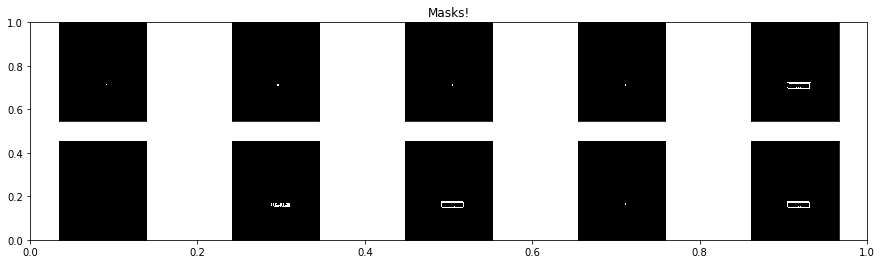

In [14]:
#We plot 1st ten masks here
plt.rcParams['figure.figsize'] = 15,4
fig = plt.figure()
plt.title('Masks!')
for mask_no in range(10):
    fig.add_subplot(2, 5, mask_no+1)
    showfig(mask_list[mask_no], plt.get_cmap('gray'))

In [15]:
validated_masklist=[]
for mask in mask_list:
    contour=np.argwhere(mask.transpose()==255)
    if validate(contour):
        validated_masklist.append(mask)

In [16]:
try:
    assert (len(validated_masklist)!=0)
except AssertionError:
    print ("No valid masks could be generated")
    exit(1)

In [17]:
# We check for repetation of masks here.
#from scipy import sum as
#import scipy.sum as scipy_sum
# This function quantifies the difference between two images in terms of RMS.
def rmsdiff(im1, im2):
    diff=im1-im2
    output=False
    if np.sum(abs(diff))/float(min(np.sum(im1), np.sum(im2)))<0.01:
        output=True
    return output

# final masklist will be the final list of masks we will be working on.
final_masklist=[]
index=[]
for i in range(len(validated_masklist)-1):
    for j in range(i+1, len(validated_masklist)):
        if rmsdiff(validated_masklist[i], validated_masklist[j]):
            index.append(j)
for mask_no in list(set(range(len(validated_masklist)))-set(index)):
    final_masklist.append(validated_masklist[mask_no])

In [18]:
cropped_images=[]
for mask in final_masklist:
    contour=np.argwhere(mask.transpose()==255)
    rect=cv2.minAreaRect(contour)
    width=int(rect[1][0])
    height=int(rect[1][1])
    centre=(int(rect[0][0]), int(rect[0][1]))
    box=cv2.boxPoints(rect) 
    box=np.int0(box)
    #check for 90 degrees rotation
    if ((width/float(height))>1):
        # crop a particular rectangle from the source image
        cropped_image=cv2.getRectSubPix(carsample_mask, (width, height), centre)
    else:
        # crop a particular rectangle from the source image
        cropped_image=cv2.getRectSubPix(carsample_mask, (height, width), centre)

    # convert into grayscale
    rendszam=cropped_image
    cropped_image=cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    # equalize the histogram
    cropped_image=cv2.equalizeHist(cropped_image)
    # resize to 260 cols and 63 rows. (Just something I have set as standard here)
    cropped_image=cv2.resize(cropped_image, (260, 63))
    cropped_images.append(cropped_image)
    

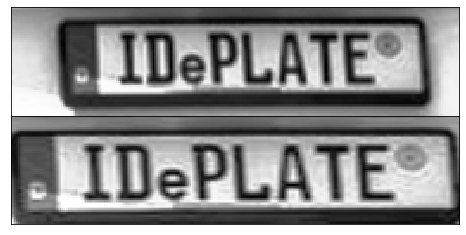

In [19]:
_=plt.subplots_adjust(hspace=0.000)
number_of_subplots=len(cropped_images)
for i,v in enumerate(range(number_of_subplots)):
    v = v+1
    ax1 = plt.subplot(number_of_subplots,1,v)
    showfig(cropped_images[i], plt.get_cmap('gray'))

In [ ]:
import numpy as np
import cv2 


img = rendszam
cv2.imshow('a rendszam', img)

cv2.waitKey(0) 

cv2.destroyAllWindows()  

In [22]:
import cv2
import pytesseract
import numpy as np
from PIL import ImageGrab
import time
 
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\tesseract.exe'
 


img = cv2.cvtColor(rendszam, cv2.COLOR_BGR2RGB)

print(pytesseract.image_to_string(img))
 
cv2.imshow('img', img)
cv2.waitKey(0)

TesseractNotFoundError: C:\Program Files\tesseract.exe is not installed or it's not in your PATH